In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

E0000 00:00:1728127926.614322      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1005 11:32:06.622276381      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1005 11:32:06.622296540      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1005 11:32:06.622299849      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1005 11:32:06.622302221      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1005 11:32:06.622304538      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [2]:
# Load the dataset
data = np.load('/kaggle/input/512gender2/Page2_1024_512_full.npz')
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1))  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1))

# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [4]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Create a strategy for distributed training
#strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728128447.781593      13 service.cc:145] XLA service 0x5ab5abb022b0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728128447.781665      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728128447.781669      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728128447.781672      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728128447.781675      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728128447.781677      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728128447.781680      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728128447.781682      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728128447.781685      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [5]:
with tpu_strategy.scope():
    # Define the base model with ImageNet weights, without the top layers
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model
    inputs = Input(shape=(512, 1024, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Custom dense layer
    outputs = Dense(2, activation='softmax')(x)  # Output layer for 2 classes

    # Create the final model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    

model.summary()

/usr/local/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
I0000 00:00:1728128451.910275      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 1024, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 16, 32, 960)    │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,119,618 (11.90 MB)

 Trainable params: 123,266 (481.51 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [6]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=32,
                    callbacks=[early_stopping])

# Save the model in .keras format
model.save('AP-MobileNetV3Large_Model_1024Gender_Trained.keras')

Epoch 1/100


2024-10-05 11:43:23.959753: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728128605.231189     790 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d1371f9b375ad526:0:0), session_name()


  1/223 ━━━━━━━━━━━━━━━━━━━━ 44:31 12s/step - accuracy: 0.2500 - loss: 0.7829

I0000 00:00:1728128611.848497     790 tpu_compile_op_common.cc:245] Compilation of d1371f9b375ad526:0:0 with session name  took 6.617260125s and succeeded
I0000 00:00:1728128611.861148     790 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d1371f9b375ad526:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_17118461430376512942", property.function_library_fingerprint = 13946660473553915884, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,1024,3,;4,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728128611.861200     790 tpu_compilation_cache_interface.cc:541] After adding entry for key

222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5586 - loss: 0.6916

I0000 00:00:1728128636.293190     793 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b73efd26fe8cf899:0:0), session_name()


223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5585 - loss: 0.6916

I0000 00:00:1728128641.341572     793 tpu_compile_op_common.cc:245] Compilation of b73efd26fe8cf899:0:0 with session name  took 5.048320727s and succeeded
I0000 00:00:1728128641.352340     793 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b73efd26fe8cf899:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_17118461430376512942", property.function_library_fingerprint = 13946660473553915884, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,1024,3,;2,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728128641.352371     793 tpu_compilation_cache_interface.cc:541] After adding entry for key

223/223 ━━━━━━━━━━━━━━━━━━━━ 94s 370ms/step - accuracy: 0.5585 - loss: 0.6916 - val_accuracy: 0.4753 - val_loss: 0.6922
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 37s 161ms/step - accuracy: 0.5406 - loss: 0.6866 - val_accuracy: 0.4798 - val_loss: 0.7015
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 37s 161ms/step - accuracy: 0.5475 - loss: 0.6855 - val_accuracy: 0.5695 - val_loss: 0.6869
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.5395 - loss: 0.6828 - val_accuracy: 0.5650 - val_loss: 0.6846
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 35s 152ms/step - accuracy: 0.5689 - loss: 0.6805 - val_accuracy: 0.5426 - val_loss: 0.6811
Epoch 6/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 34s 149ms/step - accuracy: 0.6441 - loss: 0.6675 - val_accuracy: 0.5561 - val_loss: 0.6829
Epoch 7/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - accuracy: 0.6264 - loss: 0.6682 - val_accuracy: 0.5650 - val_loss: 0.6774
Epoch 8/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - accuracy: 0.6273 - loss: 0.662

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found

In [7]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.6327 - loss: 0.7090
Test accuracy: 65.02%


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

2024-10-05 12:25:48.503520: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/MobileNetV3Large_1/conv_1/convolution/ReadVariableOp.
I0000 00:00:1728131148.827399     788 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(7fdce12507099bee:0:0), session_name()


 1/56 ━━━━━━━━━━━━━━━━━━━━ 7:48 9s/step

I0000 00:00:1728131154.128872     788 tpu_compile_op_common.cc:245] Compilation of 7fdce12507099bee:0:0 with session name  took 5.301409888s and succeeded
I0000 00:00:1728131154.151857     788 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7fdce12507099bee:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_5902610491129648299", property.function_library_fingerprint = 1572496516705283680, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728131154.151909     788 tpu_compilation_cache_interface.cc:541] After adding entry for key 7fdce1250709

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step

I0000 00:00:1728131174.355123     742 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(1577b3f62deb94c3:0:0), session_name()


56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 471ms/step


I0000 00:00:1728131180.027843     742 tpu_compile_op_common.cc:245] Compilation of 1577b3f62deb94c3:0:0 with session name  took 5.672672358s and succeeded
I0000 00:00:1728131180.040255     742 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(1577b3f62deb94c3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_17062322468134118388", property.function_library_fingerprint = 15095711349968790454, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728131180.040287     742 tpu_compilation_cache_interface.cc:541] After adding entry for 

Accuracy: 0.6303370786516854
Precision: 0.6374759045841487
Recall: 0.6304641212777695
F1 Score: 0.625610535737118
Number of Epochs: 71
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 336ms/step


<Figure size 1600x1600 with 0 Axes>

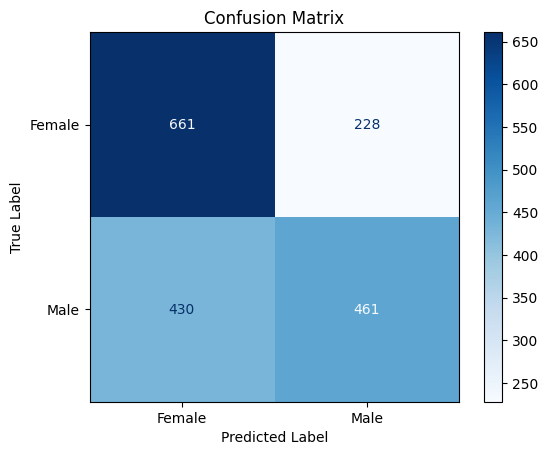

In [9]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['Female', 'Male']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

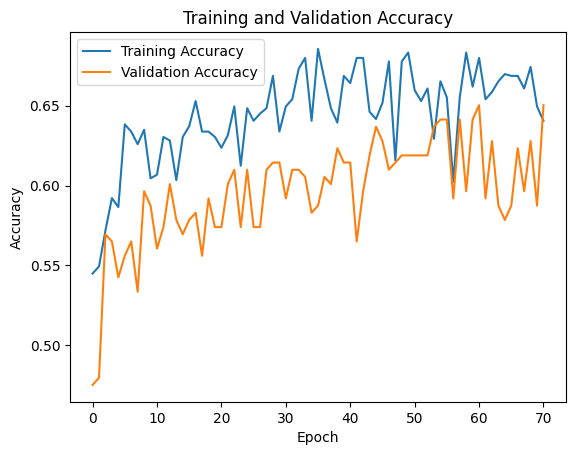

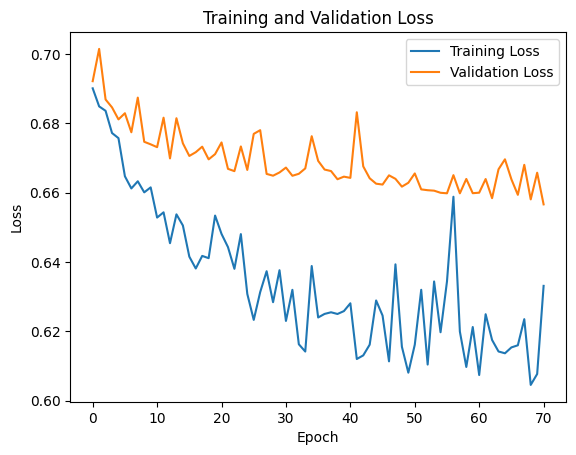

In [10]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()